# Structured Features

Using numeric and categorical values from trial data to train Random Forest Tree

In [21]:
import numpy as np
import pandas as pd

## Load CSV and Extract Features

In [22]:
# Load CSV
df_raw = pd.read_csv('raw_data/ctg-studies.csv')
print(f"Loaded {len(df_raw)} trials")
df_raw.head()

Loaded 559376 trials


,NCT Number,Study Status,Study Results,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Sponsor,Collaborators,Sex,Phases,Enrollment,Study Type,Start Date,Completion Date,Locations
0,NCT06943235,NOT_YET_RECRUITING,NO,Limited Stage Small Cell Lung Cancer,DRUG: Probiotics|RADIATION: concurrent Hyperfr...,"one year progression free survival rate, one y...","One year overall survival rate, one year|one y...",Fudan University,NaN,ALL,PHASE2,60.0,INTERVENTIONAL,2025-04-30,2027-12-30,"Fudan University Shanghai Cancer Center, Shang..."
1,NCT04241835,RECRUITING,NO,Hepatic Impairment|Advanced Malignant Solid Tumor,DRUG: Tazemetostat,To evaluate the pharmacokinetics (PK) of tazem...,To evaluate the number of participants with ad...,"Epizyme, Inc.",Sponsor GmbH,ALL,PHASE1,24.0,INTERVENTIONAL,2020-01-15,2026-03-25,Florida Cancer Specialists & Research Institut...
2,NCT04301635,UNKNOWN,NO,OSAHS|Craniofacial Abnormalities,PROCEDURE: Maxillo-mandibular Advancement + Co...,"Upper-airway morphology: Vertical length, From...","Clinical outcomes: Apnoea / hypopnoea index, F...",Hospital de Cruces,University of the Basque Country (UPV/EHU)|Bio...,ALL,NaN,38.0,OBSERVATIONAL,2019-02-04,2021-11-30,"Carlos Prol, Barakaldo, Bizkaia, 48903, Spain"
3,NCT06290635,COMPLETED,NO,ILD,DIAGNOSTIC_TEST: Breathlessness Assessment Tool,Validate Edmonton Dyspnea Inventory (EDI; form...,To perform time-motion observation of care pro...,University of Alberta,NaN,ALL,NaN,79.0,OBSERVATIONAL,2022-11-11,2025-01-31,"Kaye Edmonton Clinic, Edmonton, Alberta, T6G 2..."
4,NCT06567535,RECRUITING,NO,Jaw Cysts,PROCEDURE: Navigation and endoscopy,Rate of inferior alveolar nerve injury at one ...,"Recurrence rate one year after surgery, Recurr...",Sun Yat-Sen Memorial Hospital of Sun Yat-Sen U...,NaN,ALL,NaN,122.0,INTERVENTIONAL,2024-08-20,2026-12-30,"WangYan, Guangzhou, Guangdong, 510000, China"


In [23]:
def count_items(value):
    if pd.isna(value) or value == '':
        return 0
    return len(str(value).split('|'))

df = pd.DataFrame()

# Numeric features
df['enrollment'] = pd.to_numeric(df_raw['Enrollment'], errors='coerce').fillna(0).astype(int)
df['num_conditions'] = df_raw['Conditions'].apply(count_items)
df['num_interventions'] = df_raw['Interventions'].apply(count_items)
df['num_locations'] = df_raw['Locations'].apply(count_items)
df['num_collaborators'] = df_raw['Collaborators'].apply(count_items)
df['num_primary_outcomes'] = df_raw['Primary Outcome Measures'].apply(count_items)
df['num_secondary_outcomes'] = df_raw['Secondary Outcome Measures'].apply(count_items)

# Binary features
df['has_results'] = (df_raw['Study Results'] == 'YES').astype(int)
df['has_collaborators'] = (df['num_collaborators'] > 0).astype(int)

# Categorical features
df['phase'] = df_raw['Phases'].fillna('').astype(str)
df['study_type'] = df_raw['Study Type'].fillna('').astype(str)
df['sex'] = df_raw['Sex'].fillna('').astype(str)
df['status'] = df_raw['Study Status'].fillna('').astype(str)

# Keep NCT Number for reference
df['nct_number'] = df_raw['NCT Number']

print(f"Created {len(df)} rows with {len(df.columns)} features")
df.head()

Created 559376 rows with 14 features


,enrollment,num_conditions,num_interventions,num_locations,num_collaborators,num_primary_outcomes,num_secondary_outcomes,has_results,has_collaborators,phase,study_type,sex,status,nct_number
0,60,1,2,1,0,2,3,0,0,PHASE2,INTERVENTIONAL,ALL,NOT_YET_RECRUITING,NCT06943235
1,24,2,1,18,1,7,1,0,1,PHASE1,INTERVENTIONAL,ALL,RECRUITING,NCT04241835
2,38,2,1,1,2,8,22,0,1,,OBSERVATIONAL,ALL,UNKNOWN,NCT04301635
3,79,1,1,3,0,1,4,0,0,,OBSERVATIONAL,ALL,COMPLETED,NCT06290635
4,122,1,1,1,0,1,1,0,0,,INTERVENTIONAL,ALL,RECRUITING,NCT06567535


In [24]:
# Create target label
# Success = Completed AND has published results AND phase 2/3, 3, or 4
# (Matches baseline model definition - excludes early phase trials)
valid_phases = ['PHASE2|PHASE3', 'PHASE3', 'PHASE4']

df['label'] = (
    (df['status'] == 'COMPLETED') &
    (df['has_results'] == 1) &
    (df['phase'].isin(valid_phases))
).astype(int)

print("Target distribution:")
print(df['label'].value_counts())
print(f"\nSuccess rate: {df['label'].mean()*100:.1f}%")
print(f"\nValid phases for success: {valid_phases}")

Target distribution:
label
0    540817
1     18559
Name: count, dtype: int64

Success rate: 3.3%

Valid phases for success: ['PHASE2|PHASE3', 'PHASE3', 'PHASE4']


In [25]:
# Check feature summary
print("Feature types:")
print(df.dtypes)
print("\nCategorical value counts")
print("\nPhases:")
print(df['phase'].value_counts())
print("\nStudy types:")
print(df['study_type'].value_counts())
print("\nSex:")
print(df['sex'].value_counts())

Feature types:
enrollment                 int64
num_conditions             int64
num_interventions          int64
num_locations              int64
num_collaborators          int64
num_primary_outcomes       int64
num_secondary_outcomes     int64
has_results                int64
has_collaborators          int64
phase                     object
study_type                object
sex                       object
status                    object
nct_number                object
label                      int64
dtype: object

Categorical value counts

Phases:
phase
                 346388
PHASE2            62317
PHASE1            46332
PHASE3            40668
PHASE4            34356
PHASE1|PHASE2     16101
PHASE2|PHASE3      7274
EARLY_PHASE1       5940
Name: count, dtype: int64

Study types:
study_type
INTERVENTIONAL     427210
OBSERVATIONAL      130200
EXPANDED_ACCESS      1022
                      944
Name: count, dtype: int64

Sex:
sex
ALL       481131
FEMALE     53925
MALE       22959
 

## Handle Missing Values and Encode Categories

In [26]:
from sklearn.preprocessing import LabelEncoder

# Define valid phases (exclude early phase trials)
valid_phases_for_training = ['PHASE2', 'PHASE2|PHASE3', 'PHASE3', 'PHASE4']

# Filter out rows with missing/empty categorical values AND early phase trials
df_clean = df[
    (df['phase'].isin(valid_phases_for_training)) & 
    (df['study_type'] != '') & 
    (df['sex'] != '')
].copy()

print(f"Rows after filtering (only Phase 2, 2/3, 3, 4): {len(df_clean)} (dropped {len(df) - len(df_clean)})")

# Encode categorical variables
le_phase = LabelEncoder()
le_study_type = LabelEncoder()
le_sex = LabelEncoder()

df_clean['phase_encoded'] = le_phase.fit_transform(df_clean['phase'])
df_clean['study_type_encoded'] = le_study_type.fit_transform(df_clean['study_type'])
df_clean['sex_encoded'] = le_sex.fit_transform(df_clean['sex'])

print("\nPhase encoding (early phases excluded):")
for i, label in enumerate(le_phase.classes_):
    print(f"  {i}: {label}")

print("\nStudy type encoding:")
for i, label in enumerate(le_study_type.classes_):
    print(f"  {i}: {label}")

print("\nSex encoding:")
for i, label in enumerate(le_sex.classes_):
    print(f"  {i}: {label}")

Rows after filtering (only Phase 2, 2/3, 3, 4): 144551 (dropped 414825)

Phase encoding (early phases excluded):
  0: PHASE2
  1: PHASE2|PHASE3
  2: PHASE3
  3: PHASE4

Study type encoding:
  0: INTERVENTIONAL

Sex encoding:
  0: ALL
  1: FEMALE
  2: MALE


In [27]:
# Prepare feature matrix X and target y
feature_columns = [
    'enrollment',
    'num_conditions',
    'num_interventions', 
    'num_locations',
    'num_collaborators',
    'num_primary_outcomes',
    'num_secondary_outcomes',
    'has_collaborators',
    'phase_encoded',
    'study_type_encoded',
    'sex_encoded'
]

X = df_clean[feature_columns].values
y = df_clean['label'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {feature_columns}")
print(f"\nTarget distribution: {np.bincount(y)}")
print(f"Success rate: {y.mean()*100:.1f}%")

Feature matrix shape: (144551, 11)
Target shape: (144551,)

Features: ['enrollment', 'num_conditions', 'num_interventions', 'num_locations', 'num_collaborators', 'num_primary_outcomes', 'num_secondary_outcomes', 'has_collaborators', 'phase_encoded', 'study_type_encoded', 'sex_encoded']

Target distribution: [125994  18557]
Success rate: 12.8%


## Train Test Split and Model Training

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Training set: 115640 samples
Test set: 28911 samples

Training target distribution: [100795  14845]
Test target distribution: [25199  3712]


In [29]:
# Train Random Forest with class weights to handle imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("Done!")

Training Random Forest...
Done!


## Evaluate Model Performance

Model Performance

Accuracy:  0.687
Precision: 0.282
Recall:    0.928
F1 Score:  0.432
ROC-AUC:   0.877

Confusion Matrix
[[16416  8783]
 [  268  3444]]

Classification Report
              precision    recall  f1-score   support

     Failure       0.98      0.65      0.78     25199
     Success       0.28      0.93      0.43      3712

    accuracy                           0.69     28911
   macro avg       0.63      0.79      0.61     28911
weighted avg       0.89      0.69      0.74     28911



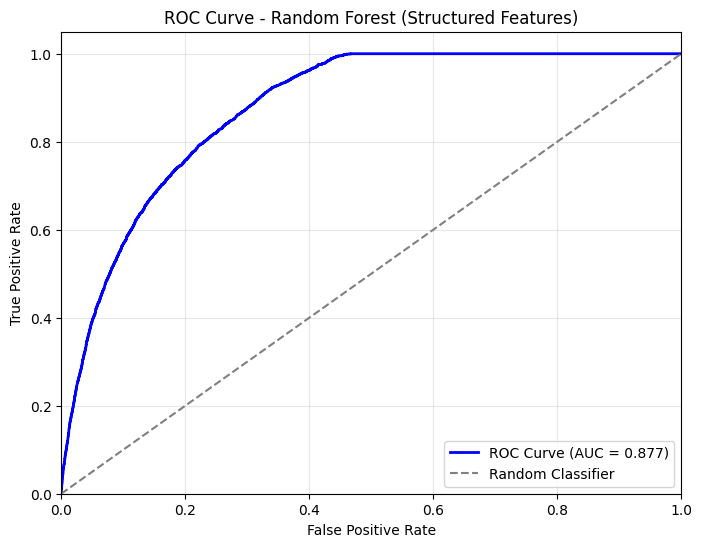

In [30]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import matplotlib.pyplot as plt

# Predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Metrics
print("Model Performance\n")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Structured Features)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()